In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform, posterior_nn
from torch import ones, zeros


sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
import bounds


In [3]:
dataset = np.load(
    "../../../arco_sims/adaptive_box_posteriors/simulation_outputs/theta_and_x.npz",
    allow_pickle=True,
)
theta = dataset["theta"].tolist()
x = dataset["x"].tolist()

### Temper the stats

In [4]:
x.keys()

dict_keys(['bAP_somatic_spike', 'bAP', 'BAC_somatic', 'BAC_caSpike', 'BAC_spikecount', 'step_mean_frequency', 'step_AI_ISIcv', 'step_doublet_ISI', 'step_AP_height', 'step_time_to_first_spike', 'step_AHP_depth', 'step_AHP_slow_time', 'step_AP_width'])

In [18]:
all_stats = []
for k in x.keys():
    np_stat = np.asarray(x[k])
    if k[:3] == "bAP" or k[:3] == "BAC":
        np_stat[np_stat < 3.1] = 3.1
    else:
        np_stat[np_stat < 4.5] = 4.5

    all_stats.append(np_stat)
all_stats = np.asarray(all_stats).T

In [25]:
theta_ = torch.as_tensor(theta, dtype=torch.float32)
x_ = torch.as_tensor(all_stats, dtype=torch.float32)

In [70]:
density_estimator = posterior_nn("nsf")
inference = SNPE(density_estimator=density_estimator)

In [71]:
inference = inference.append_simulations(theta_, x_)

In [72]:
_ = inference.train()

Neural network successfully converged after 176 epochs.


In [75]:
xo = torch.tensor([3.1, 3.1, 3.1, 3.1, 3.1, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])
posterior = inference.build_posterior().set_default_x(xo)

In [76]:
samples = posterior.sample((1000,))

In [77]:
# import pickle

In [79]:
# with open("posterior_full_nsf.pickle", "wb") as handle:
#     pickle.dump(posterior, handle)

### Check if samples lie within bounds

In [5]:
all_bounds_ = bounds.bounds_
bounds_ = all_bounds_["91", "63065090307991878"]

In [6]:
upper_ = np.asarray(list(bounds_["max"].values()))
lower_ = np.asarray(list(bounds_["min"].values()))
gt_ = np.asarray(list(bounds_["value"].values()))

In [7]:
prior = BoxUniform(
    torch.as_tensor(lower_, dtype=torch.float32),
    torch.as_tensor(upper_, dtype=torch.float32),
)

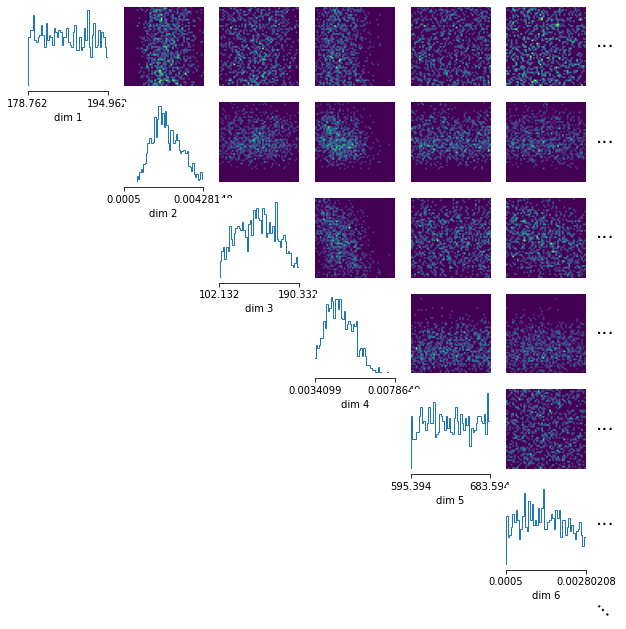

In [83]:
limits = np.asarray([lower_, upper_]).T
_ = pairplot(samples, subset=[0, 1, 2, 3, 4, 5], limits=limits, ticks=limits)

In [90]:
# with open("posterior_samples_91.pickle", "wb") as handle:
#     pickle.dump(posterior_samples, handle)

In [85]:
prior_samples = prior.sample((1000,))
posterior_samples = posterior.sample((1000,))
log_probs_prior = posterior.log_prob(prior_samples).numpy()
log_probs_posterior = posterior.log_prob(posterior_samples).numpy()

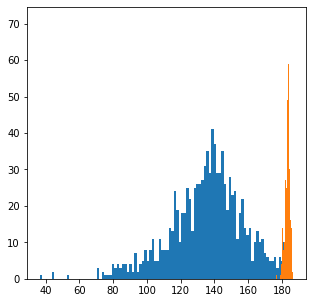

In [88]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
_ = ax.hist(log_probs_prior, bins=100)
_ = ax.hist(log_probs_posterior, bins=100)

In [89]:
prior_log_prob = prior.log_prob(torch.as_tensor(gt_, dtype=torch.float32))
posterior_log_prob = posterior.log_prob(torch.as_tensor(gt_, dtype=torch.float32))
print("Prior:  ", prior_log_prob)
print("Posterior:  ", posterior_log_prob)

Prior:   tensor(178.4547)
Posterior:   tensor([183.6339])


### Analysis

In [8]:
from sbi.analysis import conditional_pairplot
import pickle
import sbi
from sbi.analysis import conditional_corrcoeff

In [9]:
with open("posterior_full_nsf.pickle", "rb") as handle:
    posterior2 = pickle.load(handle)

In [10]:
all_bounds_ = bounds.bounds_
bounds_ = all_bounds_["91", "63065090307991878"]

upper_ = np.asarray(list(bounds_["max"].values()))
lower_ = np.asarray(list(bounds_["min"].values()))
gt_ = np.asarray(list(bounds_["value"].values()))

prior = BoxUniform(
    torch.as_tensor(lower_, dtype=torch.float32),
    torch.as_tensor(upper_, dtype=torch.float32),
)

limits = np.asarray([lower_, upper_]).T

In [11]:
samples = posterior2.sample((1000,))

In [12]:
samples_np = samples.numpy()

In [9]:
np.save("samples_arco.npy", samples_np)

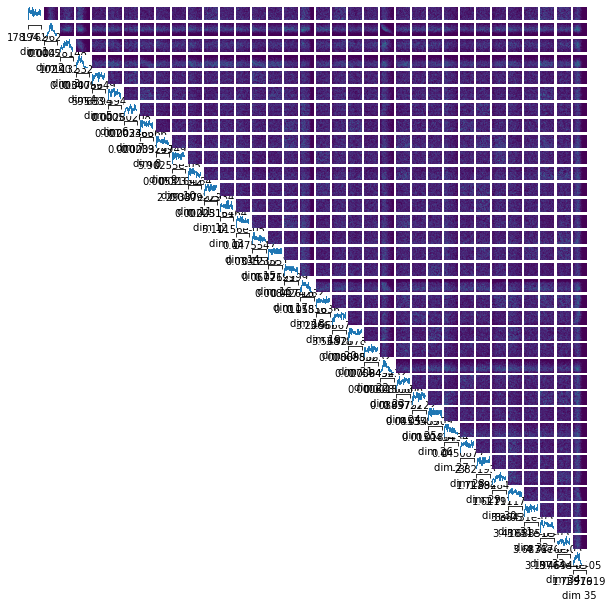

In [27]:
_ = pairplot(samples, limits=limits, ticks=limits)

### 1D marginals

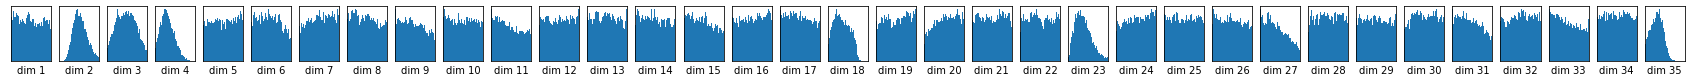

In [8]:
fraction_of_filled_space = []
fig, ax = plt.subplots(1, 35, figsize=(30, 1))
for i in range(35):
    hist_vals = ax[i].hist(samples[:, i].numpy(), bins=50, range=limits[i])
    hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
    number_above_zero = np.sum(hist_vals_bigger_zero)
    fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
    ax[i].set_xlim(limits[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(f"dim {i+1}")

In [9]:
print("Fraction of filled space (according to Arco's definition):  ", np.mean(fraction_of_filled_space))

Fraction of filled space (according to Arco's definition):   0.9857142857142858


### 2D conditional pairwise marginals

In [13]:
condition = torch.as_tensor(gt_, dtype=torch.float32)

In [15]:
NAMES = ['ephys.CaDynamics_E2.apic.decay',
            'ephys.CaDynamics_E2.apic.gamma',
            'ephys.CaDynamics_E2.axon.decay',
            'ephys.CaDynamics_E2.axon.gamma',
            'ephys.CaDynamics_E2.soma.decay',
            'ephys.CaDynamics_E2.soma.gamma',
            'ephys.Ca_HVA.apic.gCa_HVAbar',
            'ephys.Ca_HVA.axon.gCa_HVAbar',
            'ephys.Ca_HVA.soma.gCa_HVAbar',
            'ephys.Ca_LVAst.apic.gCa_LVAstbar',
            'ephys.Ca_LVAst.axon.gCa_LVAstbar',
            'ephys.Ca_LVAst.soma.gCa_LVAstbar',
            'ephys.Im.apic.gImbar',
            'ephys.K_Pst.axon.gK_Pstbar',
            'ephys.K_Pst.soma.gK_Pstbar',
            'ephys.K_Tst.axon.gK_Tstbar',
            'ephys.K_Tst.soma.gK_Tstbar',
            'ephys.NaTa_t.apic.gNaTa_tbar',
            'ephys.NaTa_t.axon.gNaTa_tbar',
            'ephys.NaTa_t.soma.gNaTa_tbar',
            'ephys.Nap_Et2.axon.gNap_Et2bar',
            'ephys.Nap_Et2.soma.gNap_Et2bar',
            'ephys.SK_E2.apic.gSK_E2bar',
            'ephys.SK_E2.axon.gSK_E2bar',
            'ephys.SK_E2.soma.gSK_E2bar',
            'ephys.SKv3_1.apic.gSKv3_1bar',
            'ephys.SKv3_1.apic.offset',
            'ephys.SKv3_1.apic.slope',
            'ephys.SKv3_1.axon.gSKv3_1bar',
            'ephys.SKv3_1.soma.gSKv3_1bar',
            'ephys.none.apic.g_pas',
            'ephys.none.axon.g_pas',
            'ephys.none.dend.g_pas',
            'ephys.none.soma.g_pas',
            'scale_apical.scale'
    ]

In [16]:
params_name_mapping = {
'ephys.NaTa_t.soma.gNaTa_tbar':'s.Na_t',
'ephys.Nap_Et2.soma.gNap_Et2bar':'s.Na_p',
'ephys.K_Pst.soma.gK_Pstbar':'s.K_p',
'ephys.K_Tst.soma.gK_Tstbar':'s.K_t',
'ephys.SK_E2.soma.gSK_E2bar':'s.SK',
'ephys.SKv3_1.soma.gSKv3_1bar':'s.Kv_3.1',
'ephys.Ca_HVA.soma.gCa_HVAbar':'s.Ca_H',
'ephys.Ca_LVAst.soma.gCa_LVAstbar':'s.Ca_L',
'ephys.CaDynamics_E2.soma.gamma':'s.Y',
'ephys.CaDynamics_E2.soma.decay':'s.T_decay',
 
'ephys.none.soma.g_pas':'s.leak',
'ephys.none.axon.g_pas':'ax.leak',
'ephys.none.dend.g_pas':'b.leak',
'ephys.none.apic.g_pas':'a.leak',
 
'ephys.NaTa_t.axon.gNaTa_tbar':'ax.Na_t',
'ephys.Nap_Et2.axon.gNap_Et2bar':'ax.Na_p',
'ephys.K_Pst.axon.gK_Pstbar':'ax.K_p',
'ephys.K_Tst.axon.gK_Tstbar':'ax.K_t',
'ephys.SK_E2.axon.gSK_E2bar':'ax.SK',
'ephys.SKv3_1.axon.gSKv3_1bar':'ax.Kv_3.1',
'ephys.Ca_HVA.axon.gCa_HVAbar':'ax.Ca_H',
'ephys.Ca_LVAst.axon.gCa_LVAstbar':'ax.Ca_L',
'ephys.CaDynamics_E2.axon.gamma':'ax.Y',
'ephys.CaDynamics_E2.axon.decay':'ax.T_decay',
 
'ephys.Im.apic.gImbar':'a.I_m',
'ephys.NaTa_t.apic.gNaTa_tbar':'a.Na_t',
'ephys.SKv3_1.apic.gSKv3_1bar':'a.Kv_3.1',
'ephys.Ca_HVA.apic.gCa_HVAbar':'a.Ca_H',
'ephys.Ca_LVAst.apic.gCa_LVAstbar':'a.Ca_L',
'ephys.SK_E2.apic.gSK_E2bar':'a.SK',
'ephys.CaDynamics_E2.apic.gamma':'a.Y',
'ephys.CaDynamics_E2.apic.decay':'a.T_decay',
 
'ephys.SKv3_1.apic.offset':'a.Kv_3.1_offset',
'ephys.SKv3_1.apic.slope':'a.Kv_3.1_slope',
'scale_apical.scale': 'a.scale'
}

In [17]:
names_ = list(params_name_mapping.values())

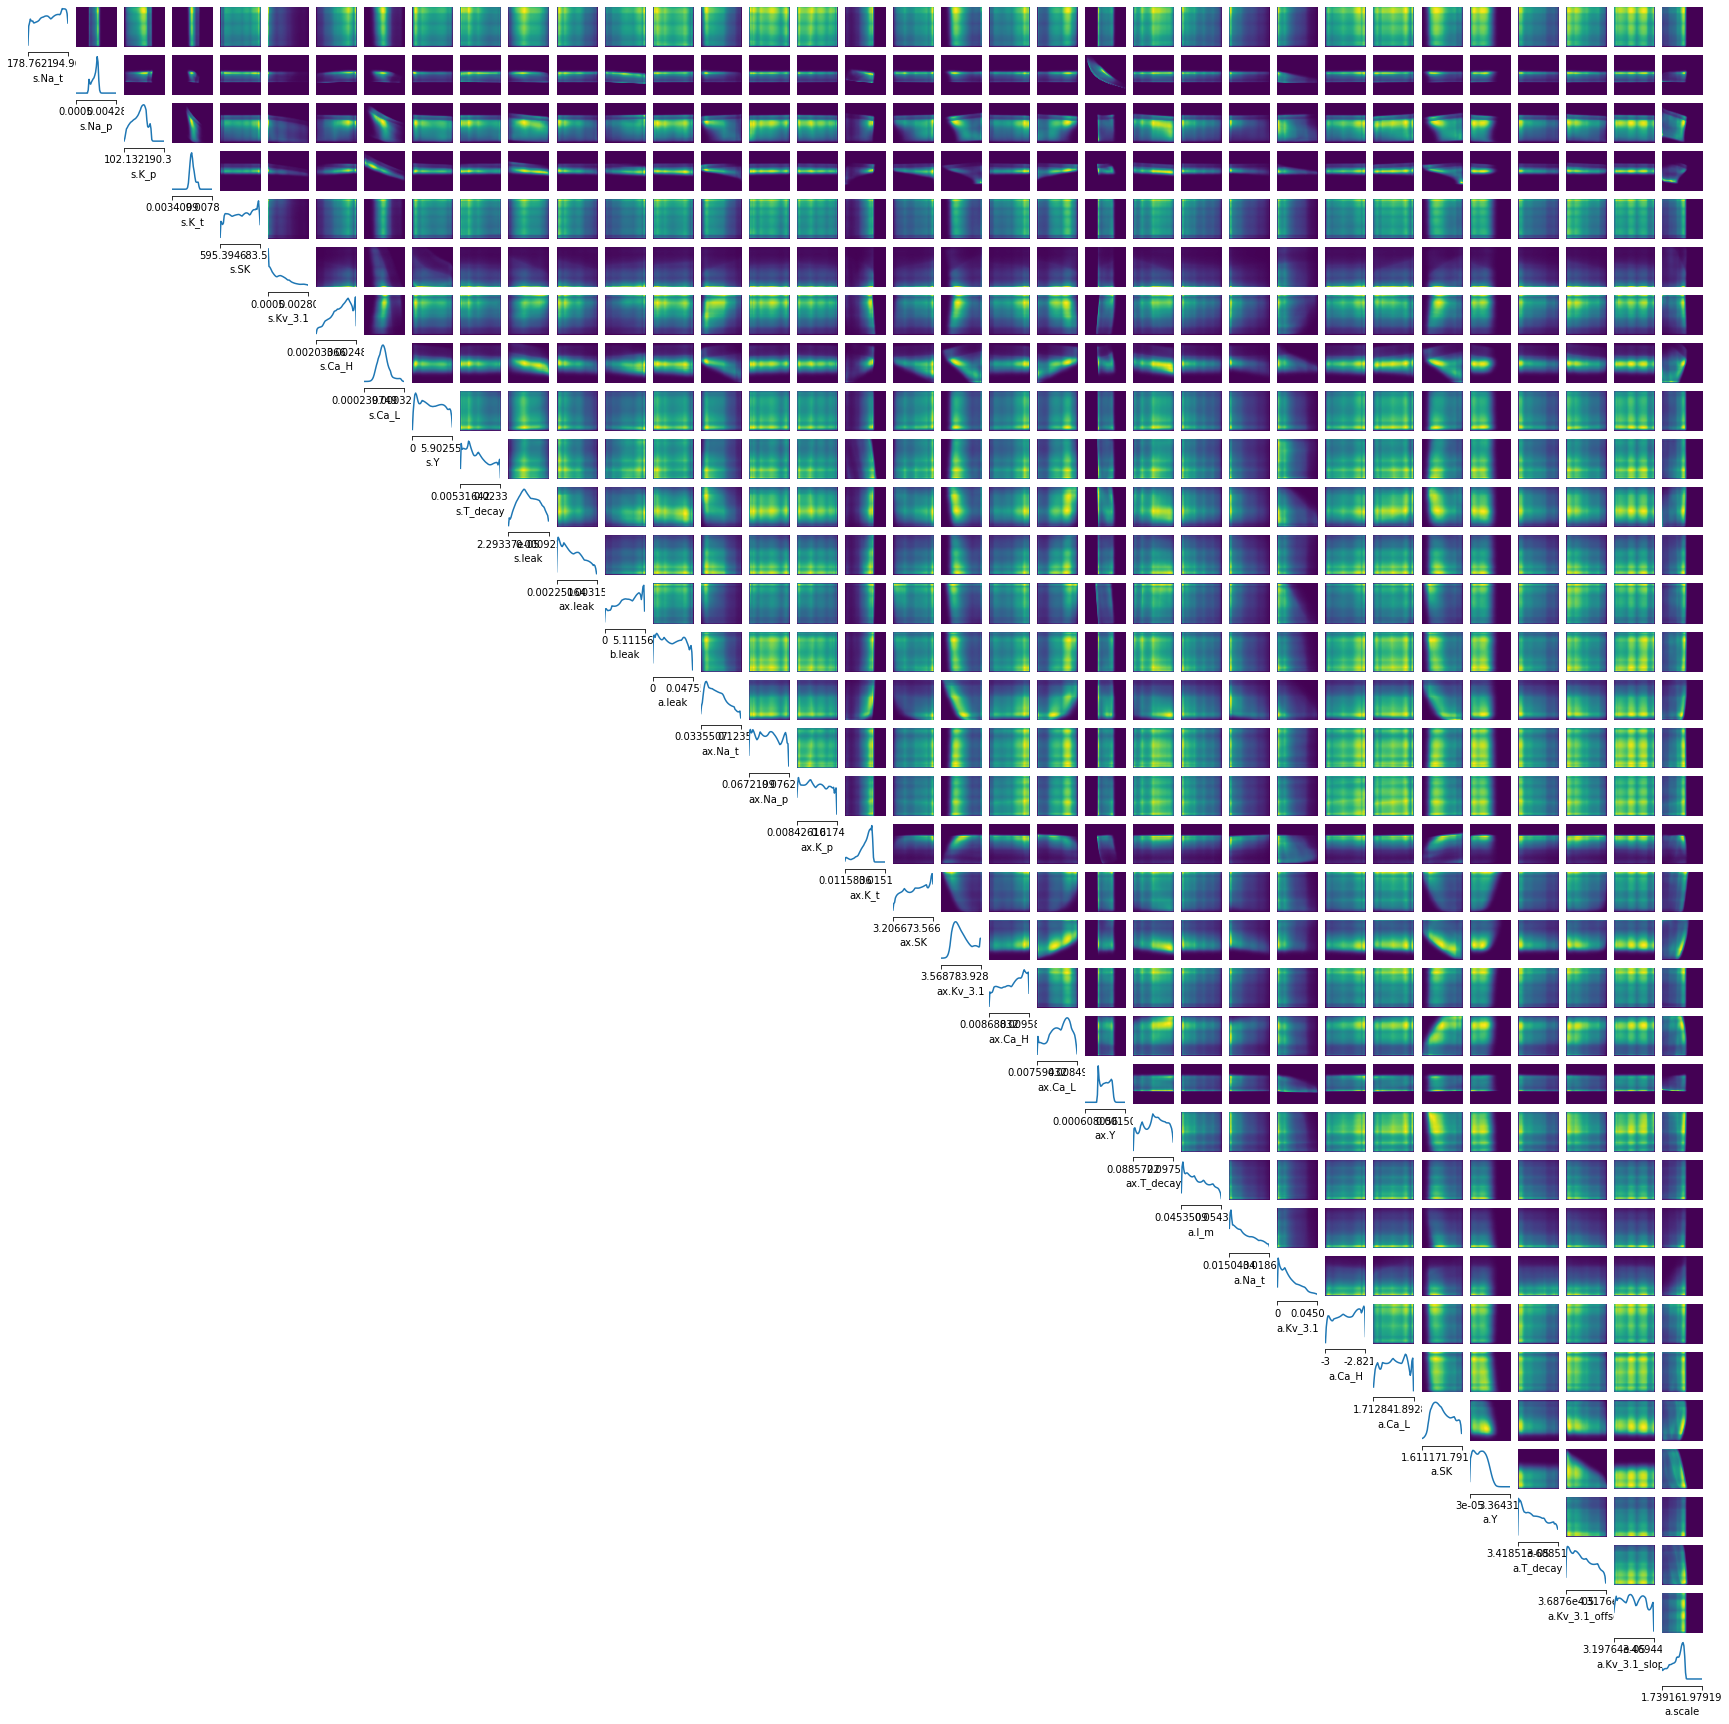

In [39]:
_ = conditional_pairplot(posterior2, condition=condition, limits=limits, labels=names_, ticks=limits, figsize=(30,30))

In [18]:
corrcoeff = conditional_corrcoeff(posterior2, condition=condition, limits=torch.as_tensor(limits, dtype=torch.float32))

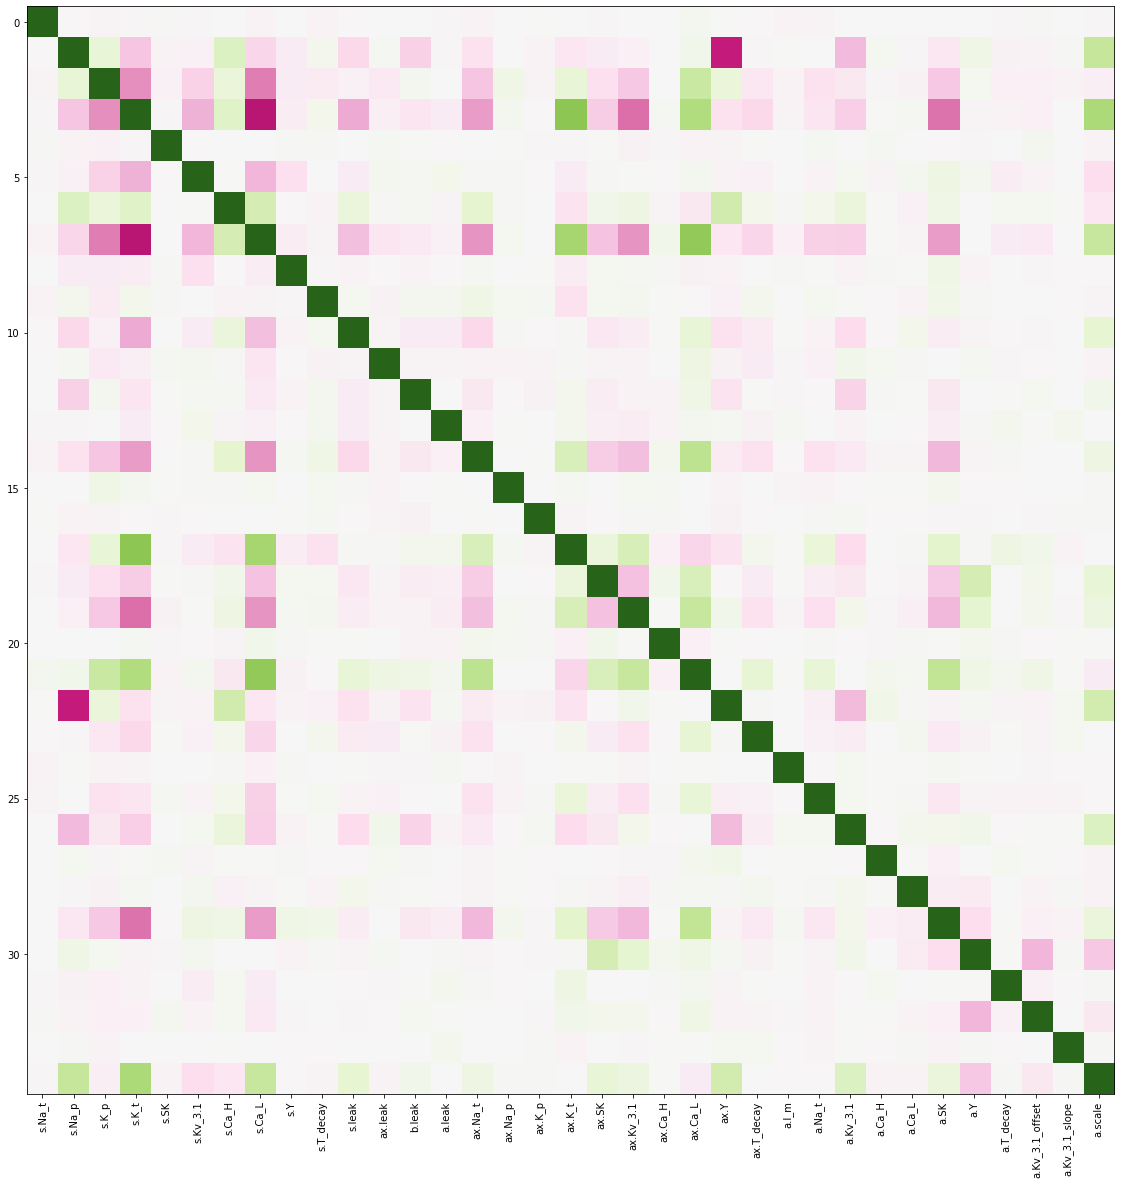

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))
_ = ax.imshow(corrcoeff, clim=[-1, 1], cmap='PiYG')
_ = ax.set_xticks(range(35))
_ = ax.set_xticklabels(names_, rotation=90)
plt.savefig("conditional_correlations_1d.png", dpi=200, bbox_inches="tight", facecolor='w')

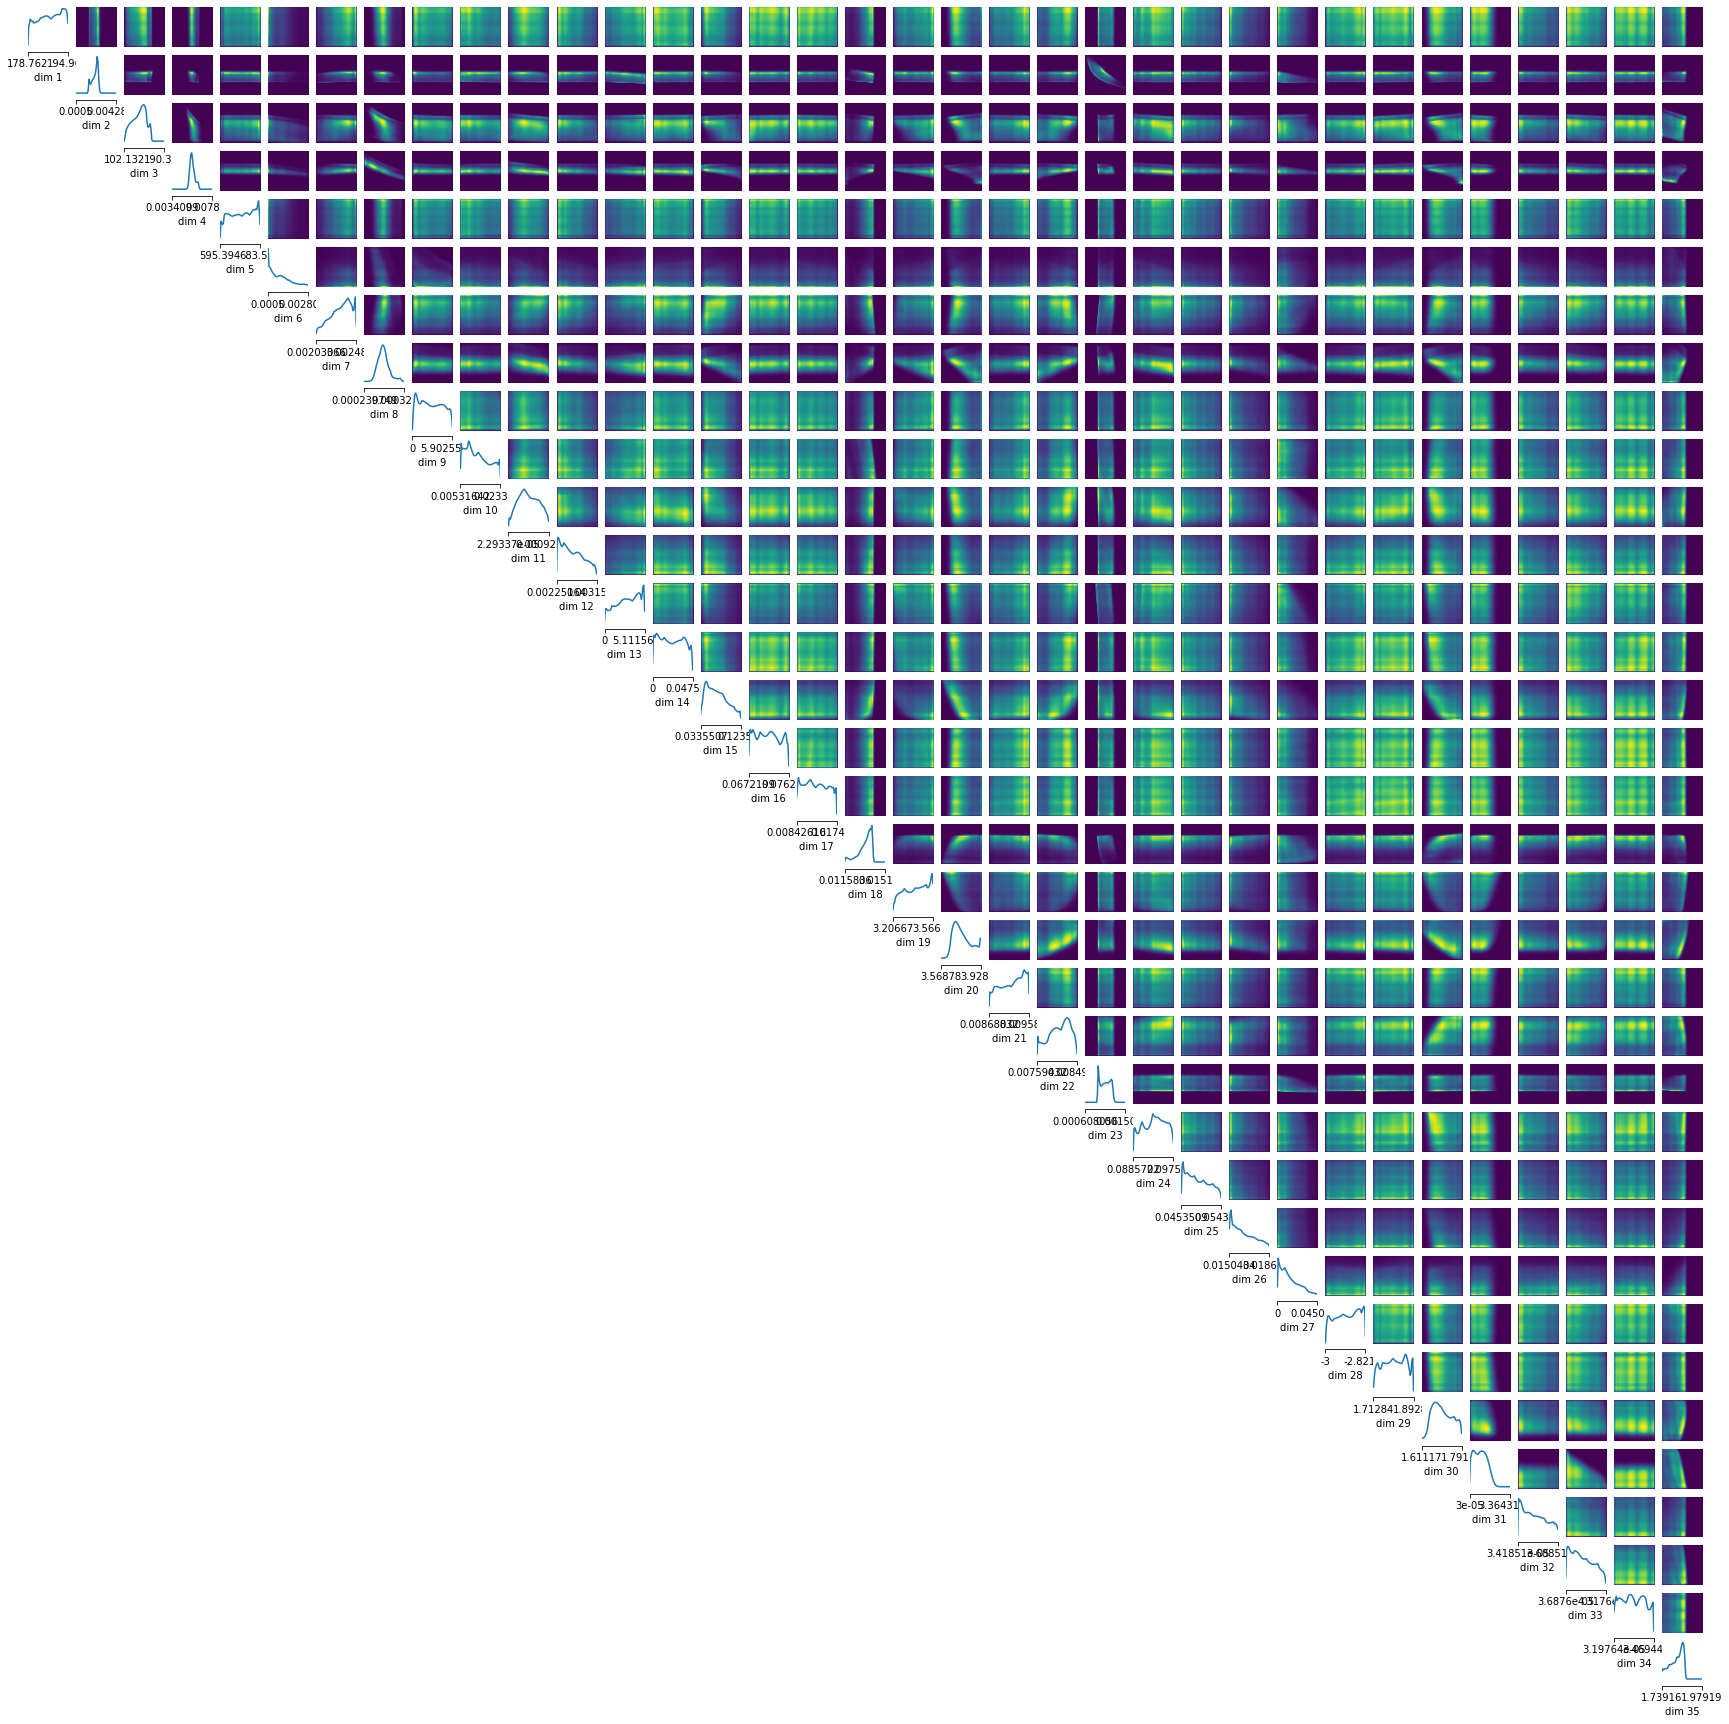

In [17]:
_ = conditional_pairplot(posterior2, condition=condition, limits=limits, labels=NAMES, ticks=limits, figsize=(30,30))

### Get fraction of filled space for 1D conditional

In [12]:
from sbi.analysis import eval_conditional_density

In [13]:
log_prob_of_condition = posterior2.log_prob(condition)

In [14]:
log_prob_of_condition

tensor([183.6339])

In [15]:
limits_diffs = limits[:, 1] - limits[:, 0]
eps_margins = limits_diffs / 1e5

In [16]:
row = 0
resolution = 50

all_log_prob_vecs = []
for row in range(35):
    p_vector = eval_conditional_density(
        posterior2,
        condition,
        limits,
        row,
        row,
        resolution=resolution,
        eps_margins1=eps_margins[row],
        eps_margins2=eps_margins[row],
        return_raw_log_prob=True
    )
    all_log_prob_vecs.append(p_vector)
all_log_prob_vecs = torch.stack(all_log_prob_vecs)

In [17]:
max_val = log_prob_of_condition
all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)

In [18]:
above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0

In [19]:
fractions_1d_cond = torch.sum(above_thr, axis=1) / resolution

(0.4, 35.5)

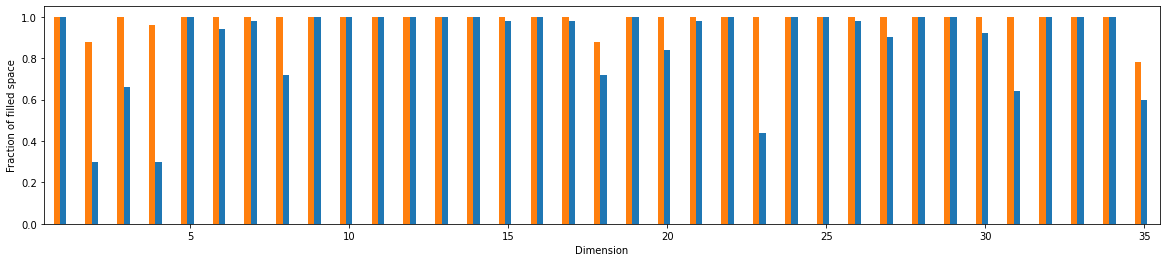

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20, 4))
ax.bar(np.arange(35)+1.0, fractions_1d_cond.numpy(), width=0.2)
ax.bar(np.arange(35)-0.2+1.0, fraction_of_filled_space, width=0.2)
ax.set_xlabel("Dimension")
ax.set_ylabel("Fraction of filled space")
ax.set_xlim([0.4, 35.5])

### Add a second parameter and see again

In [21]:
row = 0
resolution = 50
all_fractions_2d_cond = []

for col in range(35):
    all_log_prob_vecs = []
    for row in range(35):
        if row != col:
            p_vector = eval_conditional_density(
                posterior2,
                condition,
                limits,
                row,
                col,
                resolution=resolution,
                eps_margins1=eps_margins[row],
                eps_margins2=eps_margins[col],
                return_raw_log_prob=True
            )
            all_log_prob_vecs.append(p_vector)
    all_log_prob_vecs = torch.stack(all_log_prob_vecs)

    max_val = log_prob_of_condition
    all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)
    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    any_above_thr_in_col = torch.any(above_thr, axis=2)
    fractions_2d_cond = torch.sum(any_above_thr_in_col, axis=1) / resolution
    max_rev = any_above_thr_in_col
    max_rev[max_rev == torch.max(fractions_2d_cond).item()] = float(-1e20)
    all_fractions_2d_cond.append(torch.max(max_rev).item())

In [201]:
row = 0
resolution = 50
all_fractions_2d_cond = []

for col in range(35):
    all_log_prob_vecs = []
    for row in range(35):
        if row != col:
            p_vector = eval_conditional_density(
                posterior2,
                condition,
                limits,
                row,
                col,
                resolution=resolution,
                eps_margins1=eps_margins[row],
                eps_margins2=eps_margins[col],
                return_raw_log_prob=True
            )
            all_log_prob_vecs.append(p_vector)
    all_log_prob_vecs = torch.stack(all_log_prob_vecs)

    max_val = log_prob_of_condition
    all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)
    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    any_above_thr_in_col = torch.any(above_thr, axis=2)
    fractions_2d_cond = torch.sum(any_above_thr_in_col, axis=1) / resolution
    all_fractions_2d_cond.append(torch.max(fractions_2d_cond).item())

fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(0.8400)
fractions_1d_cond tensor(0.9000)
fractions_1d_cond tensor(0.6600)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(0.8000)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(0.9800)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tensor(1.)
fractions_1d_cond tenso

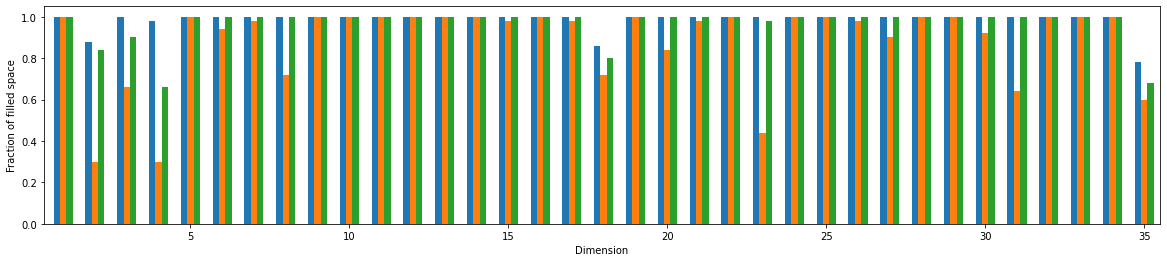

In [220]:
fig, ax = plt.subplots(1,1, figsize=(20, 4))
ax.bar(np.arange(35)-0.2+1.0, fraction_of_filled_space, width=0.2)
ax.bar(np.arange(35)+1.0, fractions_1d_cond.numpy(), width=0.2)
ax.bar(np.arange(35)+0.2+1.0, all_fractions_2d_cond, width=0.2)
ax.set_xlabel("Dimension")
ax.set_ylabel("Fraction of filled space")
ax.set_xlim([0.4, 35.5])
plt.savefig("compensation_results.png", dpi=300, bbox_inches="tight")